# Computed Generated Holography using DMD
We trained a binary amplitude mask (DMD) to generate holography using the surrogate gradient method.

Conference presentation: M. Hossein Eybposh, Aram Moossavi, Vincent R. Curtis, and Nicolas C. Pegard "Optimization of time-multiplexed computer-generated holograms with surrogate gradients", Proc. SPIE PC12014, Emerging Digital Micromirror Device Based Systems and Applications XIV, PC1201406 (9 March 2022); https://doi.org/10.1117/12.2607781M. 

In [ ]:
# If in colab, install Jax and chromatix. Don't forget to select a GPU!
!pip install --upgrade pip
!pip install "jax[cuda11_cudnn82]==0.4.1" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install git+https://github.com/TuragaLab/chromatix.git

In [1]:
import jax
import jax.numpy as jnp
from jax import random
import flax.linen as nn
from optax import adam
import optax

from time import time 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from skimage.data import cat

from chromatix.elements import PlaneWave, PhaseMask, FFLens, Propagate,GenericBeam, AmplitudeMask
from chromatix.functional import empty_field, plane_wave, transfer_propagate
from chromatix.utils import trainable
from typing import Sequence, Callable, Any

key = random.PRNGKey(4)

## Creating a target hologram

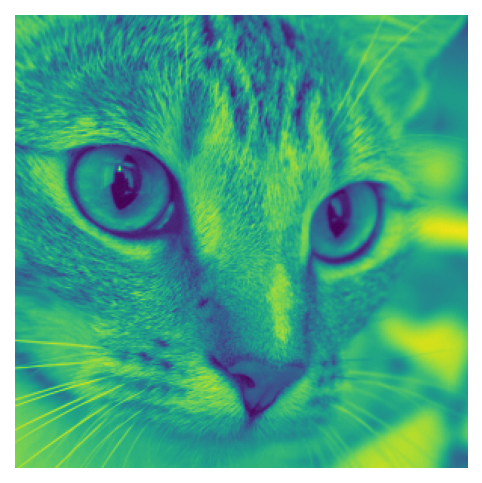

In [2]:
im = cat().mean(2)
im = im[:, 100:400]
plt.figure(dpi=150)
plt.imshow(im)
plt.axis("off")
plt.show()

## Constructing the model

In [3]:
init = random.uniform(key, shape=im.shape, minval=0, maxval=1)
class CGH(nn.Module):
    @nn.compact
    def __call__(self, z):
        field = empty_field(shape=im.shape, dx=7.56, spectrum=0.66, spectral_density=1.0)
        field = plane_wave(field, kykx = (0, 0))
        field1 = AmplitudeMask(trainable(init), is_binary=True)(field)
        field2 = transfer_propagate(field1, z=z, n=1, N_pad=0)
        return field2

def loss_fn(params, data, z):
    approx = model.apply(params, z=z).intensity.squeeze() 
    loss = optax.cosine_distance(predictions=approx.reshape(-1),
                            targets=data.reshape(-1),
                            epsilon=1e-6).mean()
    return loss, {"loss": loss}

def step_fn(loss_fn, optimizer):
    def step(params, opt_state, *args):
        (_, metrics), grads = jax.value_and_grad(loss_fn, allow_int=True, has_aux=True)(
            params, *args
        )
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, metrics
    return step


In [4]:
z = 13e4
model = CGH() 
params = model.init(key, z)
data = jnp.array(im)

## Optimization

In [5]:
start = time()
optimizer = adam(learning_rate=2)
opt_state = optimizer.init(params)
step = jax.jit(step_fn(loss_fn, optimizer))

max_iterations = 400
history = []
for iteration in range(max_iterations):
    params, opt_state, metrics = step(params, opt_state, data, z)
    history.append(metrics["loss"])
    if iteration % 20 == 0:
        print(f'iteration {iteration} {history[-1]}')
        approx1 = model.apply(params, z=z).intensity.squeeze() 
end = time()

print(f'Total time: {(end - start)}s')
print(f'Time per iteration: {(end - start) / max_iterations}s')

iteration 0 0.2709755301475525
iteration 20 0.0984349250793457
iteration 40 0.09412229061126709
iteration 60 0.09206044673919678
iteration 80 0.09189748764038086
iteration 100 0.09108603000640869
iteration 120 0.09035664796829224
iteration 140 0.08970820903778076
iteration 160 0.0892985463142395
iteration 180 0.08877074718475342
iteration 200 0.08782768249511719
iteration 220 0.08732140064239502
iteration 240 0.08708441257476807
iteration 260 0.08680284023284912
iteration 280 0.08683180809020996
iteration 300 0.08595550060272217
iteration 320 0.08565735816955566
iteration 340 0.0853014588356018
iteration 360 0.08511734008789062
iteration 380 0.08503198623657227
Total time: 1.9474549293518066s
Time per iteration: 0.004868637323379516s


## Visualization

0.08485627


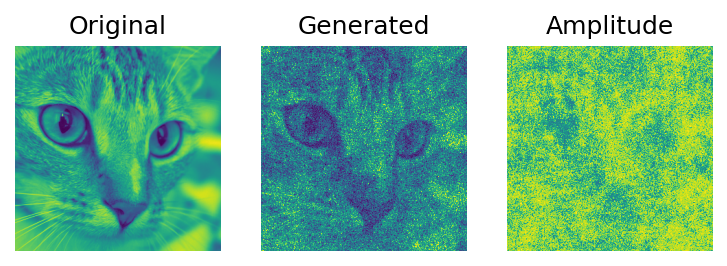

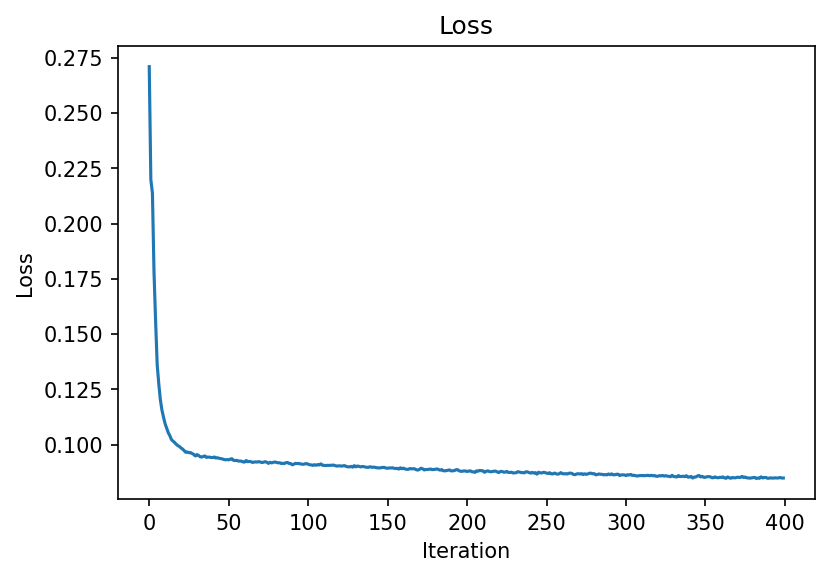

In [6]:
plt.figure(dpi=150)
plt.subplot(1, 3, 1)
plt.axis("off")
plt.imshow(data); plt.title('Original')
plt.subplot(1, 3, 2)
plt.imshow(approx1, vmax=np.percentile(approx1, 99)); plt.title('Generated')
plt.axis("off")
plt.subplot(1, 3, 3)
amp = params['params']['AmplitudeMask_0']['amplitude_pixels'].squeeze()
plt.imshow(amp, vmax=np.percentile(amp, 99)); plt.title('Amplitude')
plt.axis("off")

plt.figure(dpi=150)
plt.plot(history)
plt.title('Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
print(history[-1])

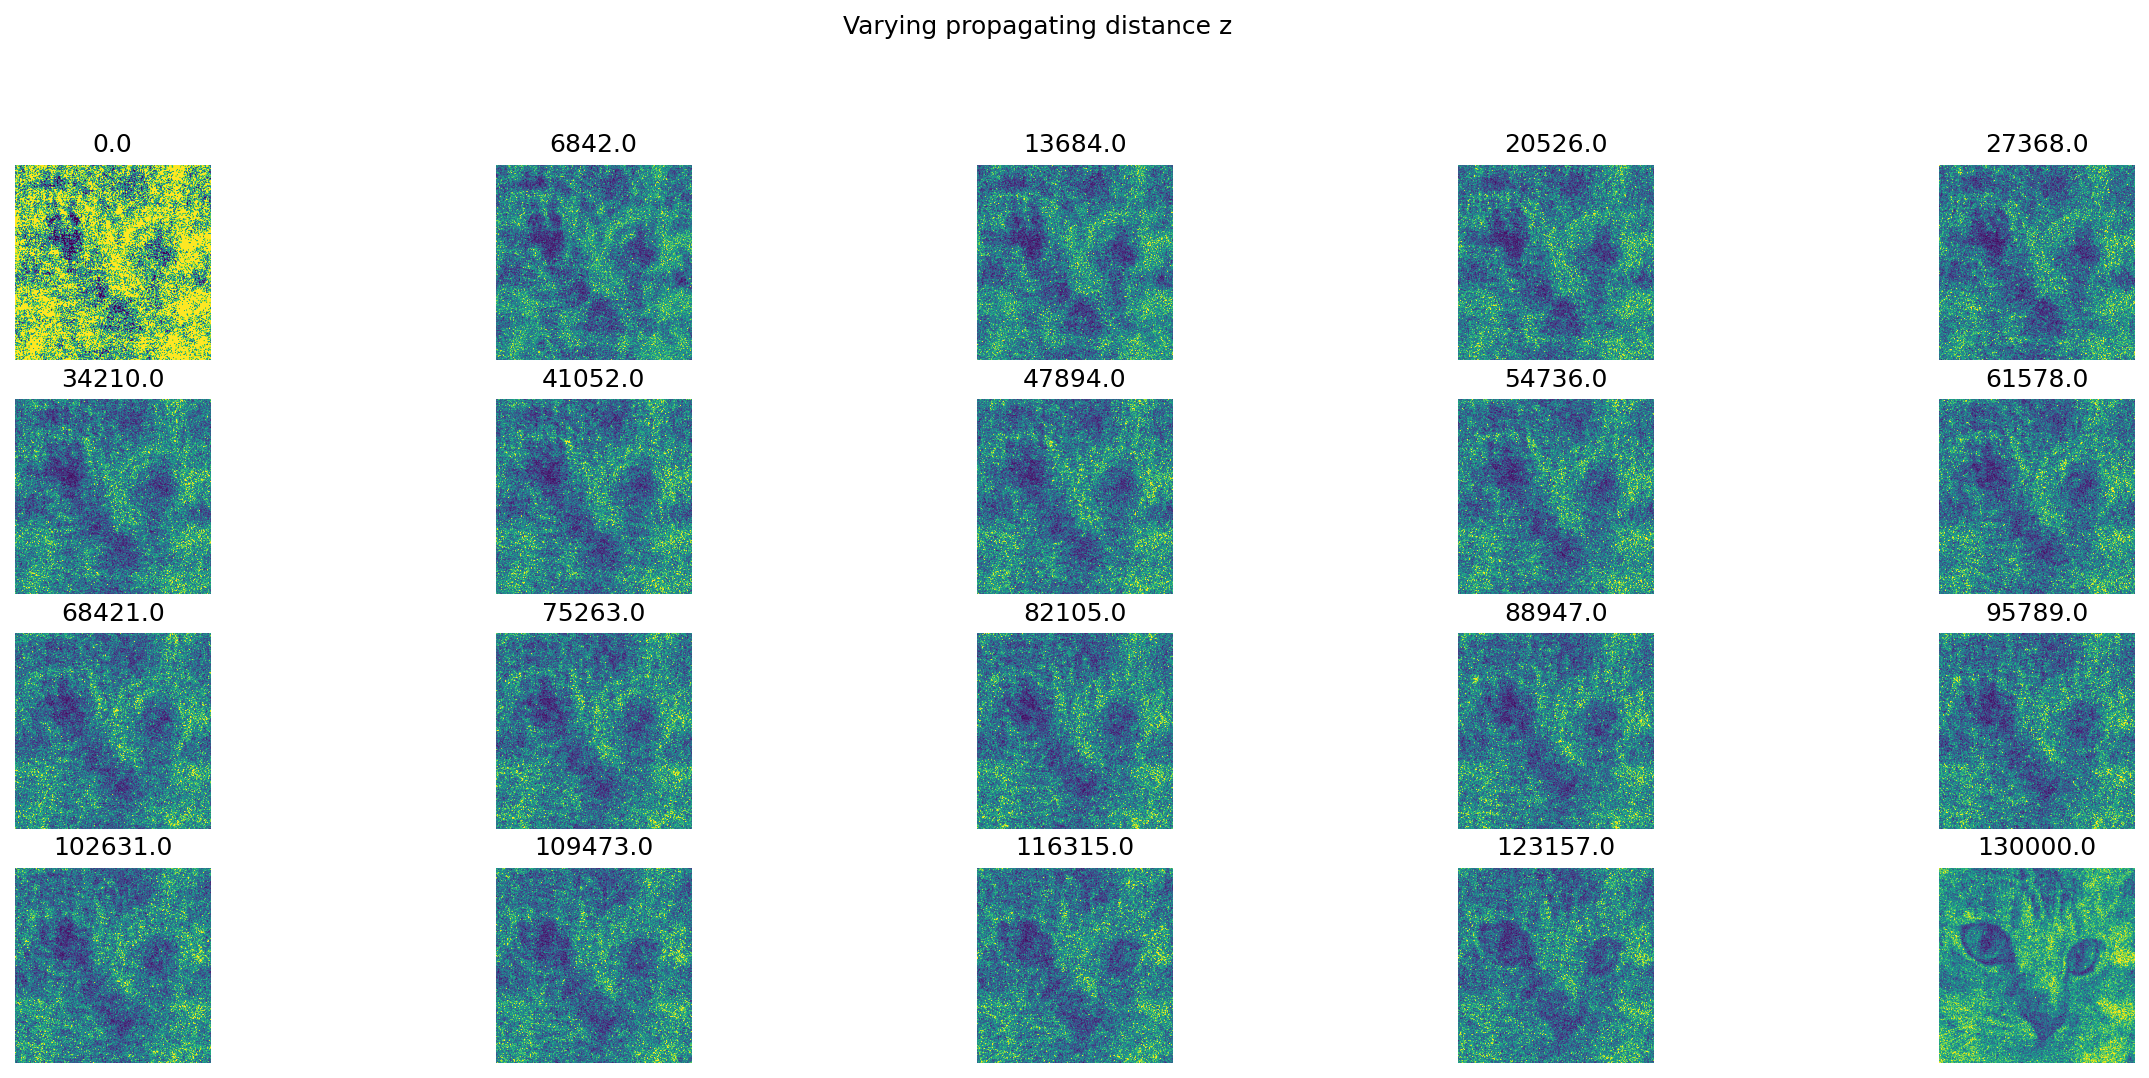

In [7]:
z_list = np.linspace(0., z, 20)
images = model.apply(params, z=z_list).intensity.squeeze() 

plt.figure(figsize=(20,10), dpi=150)
plt.suptitle("Varying propagating distance z")

columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) // columns + 1, columns, i + 1)
    plt.imshow(image, vmax=np.percentile(image, 95))
    plt.axis("off")    
    plt.title(f'{z_list[i].squeeze()//1}') 